# Multiary complex model of GPCR signaling activations

This notebook is the Supplemental Material for ``Watabe et al. Multiary complex formations in GPCR signaling activations. arXiv:xxx.xxxxxx (2020)".

In [1]:
!pip install ecell4

In [0]:
# Multiary Complex Model in GPCR signaling activation
import os
import sys
import numpy

%matplotlib inline
# get_ipython().run_line_magic('matplotlib', 'inline')
import matplotlib.pylab as plt

from ecell4 import *
from ecell4_base.core import *
from ecell4_base import gillespie, ode

## Parameters

In [0]:
class ParConfigs() :

    '''
    Set Parameters
    '''

    # Set model parameters 
    def __init__(self, user_configs_dict = None):

        self.A = 10000. # Cell-Area: µm^2
        self.T = 4.977 # Receptor concetration: receptors/µm^2
        self.r0 = int(self.T*self.A)

        # ligand-receptor first-order interactions
        # Phi  <==> M
        # Phi' <==> M'
        # M'   <==> D'
        # dissociation rates
        self.dl0 = 1.00 # 1/sec
        self.dl1 = 1.00 # 1/sec
        self.dl2 = 1.00 # 1/sec

        # equilibrium constants
        self.Kl0 = 1.00 # nM
        self.Kl1 = None
        self.Kl2 = None

        # receptor-Gprotein first-order interactions
        # Phi  <==> G Phi
        # Phi' <==> G Phi'
        # dissociation rates
        self.dg0 = 1.00 # 1/sec
        self.dg1 = 1.00 # 1/sec
    
        # equilibrium constants
        self.Kg0 = 1.00 # nM
        self.Kg1 = None
   
        # ligand-(receptor-Gprotein) first-order interactions
        # G Phi  <==> G M
        # G Phi' <==> G M'
        # G M'   <==> G D'
        # dissociation rates
        self.da0 = 1.00 # 1/sec
        self.da1 = 1.00 # 1/sec
        self.da2 = 1.00 # 1/sec
    
        # equilibrium constants
        self.Ka0 = 1.00 # nM
        self.Ka1 = None
        self.Ka2 = None
   
        # Gprotein-(ligand-receptor) first-order interactions 
        # M  <==> G M
        # M' <==> G M'
        # D' <==> G D'
        # dissociation rates
        self.db0 = 1.00 # 1/sec
        self.db1 = 1.00 # 1/sec
        self.db2 = 1.00 # 1/sec
    
        # equilibrium constants
        self.Kb0 = 1.00 # nM
        self.Kb1 = None
        self.Kb2 = None
    
        # receptor-receptor interactions:
        # Phi + Phi <==> Phi'
        # M   + Phi <==> M'
        # M   + M   <==> D'
        # dissociation rates
        self.dx0 = 1.00 # 1/sec
        self.dx1 = 1.00 # 1/sec
        self.dx2 = 1.00 # 1/sec

        # equilibrium constants
        self.Kx0 = None
        self.Kx1 = None
        self.Kx2 = None

        # receptor-Gprotein coupling
        # G Phi + Phi <==> G Phi'
        # G M   + Phi <==> G M'
        # G Phi + M   <==> G M'
        # G M   + M   <==> G D'
        # dissociation rates
        self.dy0 = 1.00 # 1/sec
        self.dy1 = 1.00 # 1/sec
        self.dy2 = 1.00 # 1/sec
        self.dy3 = 1.00 # 1/sec

        # equilibrium constants
        self.Ky0 = None
        self.Ky1 = None
        self.Ky2 = None
        self.Ky3 = None

    def get_r0(self):

        r0 = self.r0

        return r0

    def get_dl(self):

        dl0 = self.dl0
        dl1 = self.dl1
        dl2 = self.dl2

        return dl0, dl1, dl2

    def get_kl(self, sigma_l1, sigma_l2):

        self.Kl1 = sigma_l1*self.Kl0
        self.Kl2 = sigma_l2*self.Kl0

        kl0 = self.dl0/self.Kl0 # 1/(sec nM)
        kl1 = self.dl1/self.Kl1 # 1/(sec nM)
        kl2 = self.dl2/self.Kl2 # 1/(sec nM)

        return kl0, kl1, kl2

    def get_dg(self):

        dg0 = self.dg0
        dg1 = self.dg1

        return dg0, dg1

    def get_kg(self, sigma_g1):

        self.Kg1 = sigma_g1*self.Kg0

        kg0 = self.dg0/self.Kg0
        kg1 = self.dg1/self.Kg1

        return kg0, kg1

    def get_da(self):

        da0 = self.da0
        da1 = self.da1
        da2 = self.da2

        return da0, da1, da2

    def get_ka(self, alpha, sigma_a1, sigma_a2):

        self.Ka0 = alpha*self.Kl0
        self.Ka1 = sigma_a1*self.Ka0
        self.Ka2 = sigma_a2*self.Ka0

        ka0 = self.da0/self.Ka0
        ka1 = self.da1/self.Ka1
        ka2 = self.da2/self.Ka2

        return ka0, ka1, ka2

    def get_db(self):

        db0 = self.db0
        db1 = self.db1
        db2 = self.db2

        return db0, db1, db2

    def get_kb(self, beta, sigma_b1, sigma_b2):

        self.Kb0 = beta*self.Kg0
        self.Kb1 = sigma_b1*self.Kb0
        self.Kb2 = sigma_b2*self.Kb0

        kb0 = self.db0/self.Kb0
        kb1 = self.db1/self.Kb1
        kb2 = self.db2/self.Kb2

        return kb0, kb1, kb2

    def get_dx(self):

        dx0 = self.dx0
        dx1 = self.dx1
        dx2 = self.dx2

        return dx0, dx1, dx2

    def get_kx(self, kx, N):

        self.Kx0 = self.T/kx # 1/µm^2
        self.Kx1 = (self.Kl1*self.Kx0)/self.Kl0 # 1/µm^2
        self.Kx2 = (self.Kl2*self.Kl1*self.Kx0)/(self.Kl0**2) # 1/µm^2

        kx0 = self.dx0/self.Kx0 # µm^2/sec
        kx1 = self.dx1/self.Kx1 # µm^2/sec
        kx2 = self.dx2/self.Kx2 # µm^2/sec

        return kx0/N, kx1/N, kx2/N

    def get_dy(self):

        dy0 = self.dy0
        dy1 = self.dy1
        dy2 = self.dy2
        dy3 = self.dy3

        return dy0, dy1, dy2, dy3

    def get_ky(self, sigma_y0, sigma_y1, sigma_y2, sigma_y3):

        self.Ky0 = sigma_y0*self.Kx0
        self.Ky1 = sigma_y1*self.Kx1
        self.Ky2 = sigma_y2*self.Kx1
        self.Ky3 = sigma_y3*self.Kx2

        ky0 = self.dy0/self.Ky0 # µm^2/sec
        ky1 = self.dy1/self.Ky1 # µm^2/sec
        ky2 = self.dy2/self.Ky2 # µm^2/sec
        ky3 = self.dy3/self.Ky3 # µm^2/sec

        return ky0, ky1, ky2, ky3


In [0]:
def run_N0(m, mols, obs0):
    # Create simulator (ODE)
    w = ode.World()
    w.bind_to(m)
    sim = ode.Simulator(w)

    # Initialization
    print ("Initial condition")
    for i in range(len(mols)) :
      obs0_i = int(round(obs0[i]))
      w.add_molecules(Species("%s" % (mols[i])), obs0_i)
      print (mols[i], ':', obs0_i)

    sim.initialize()

    # Run simulator
    period = 50. # sec

    obs = FixedIntervalNumberObserver(1.0, mols)
    sim.run(period, [obs])
    obs_data = numpy.array(obs.data())

    time = obs_data[:,0]
    R0 = obs_data[:,1]
    RM = numpy.zeros(shape=(len(time)))
    RD = obs_data[:,2]
    G0 = obs_data[:,3]
    GM = obs_data[:,4]
    GD = numpy.zeros(shape=(len(time)))

    data = obs_data.T

    plt.plot(data[0], RM+RD+GM+GD, "b-", label="Bound states")
    plt.plot(data[0], RM, "-", label="M")
    plt.plot(data[0], RD, "-", label="D")
    plt.plot(data[0], GM, "-", label="G•M")
    plt.plot(data[0], GM, "-", label="G•D")

    plt.xlabel("Time [sec]")
    plt.ylabel("Bounds")
    plt.xlim(data[0][0], data[0][-1])
    plt.legend(loc="best", shadow=True)
    plt.show()

In [0]:
def run_N1(m, mols, obs0):
    # Create simulator (ODE)
    w = ode.World()
    w.bind_to(m)
    sim = ode.Simulator(w)

    # Initialization
    print ("Initial condition")
    for i in range(len(mols)) :
      obs0_i = int(round(obs0[i]))
      w.add_molecules(Species("%s" % (mols[i])), obs0_i)
      print (mols[i], ':', obs0_i)

    sim.initialize()

    # Run simulator
    period = 50. # sec

    obs = FixedIntervalNumberObserver(1.0, mols)
    sim.run(period, [obs])
    obs_data = numpy.array(obs.data())

    time = obs_data[:,0]
    R0 = obs_data[:,1] + obs_data[:,2]
    RM = obs_data[:,3] + obs_data[:,4]
    RD = obs_data[:,5]
    G0 = obs_data[:,6] + obs_data[:,7]
    GM = obs_data[:,8] + obs_data[:,9]
    GD = obs_data[:,10]

    data = obs_data.T

    plt.plot(data[0], RM+RD+GM+GD, "b-", label="Bound states")
    plt.plot(data[0], RM, "-", label="M")
    plt.plot(data[0], RD, "-", label="D")
    plt.plot(data[0], GM, "-", label="G•M")
    plt.plot(data[0], GM, "-", label="G•D")

    plt.xlabel("Time [sec]")
    plt.ylabel("Bounds")
    plt.xlim(data[0][0], data[0][-1])
    plt.legend(loc="best", shadow=True)
    plt.show()

In [0]:
def run_N2(m, mols, obs0):
    # Create simulator (ODE)
    w = ode.World()
    w.bind_to(m)
    sim = ode.Simulator(w)

    # Initialization
    print ("Initial condition")
    for i in range(len(mols)) :
      obs0_i = int(round(obs0[i]))
      w.add_molecules(Species("%s" % (mols[i])), obs0_i)
      print (mols[i], ':', obs0_i)

    sim.initialize()

    # Run simulator
    period = 50. # sec

    obs = FixedIntervalNumberObserver(1.0, mols)
    sim.run(period, [obs])
    obs_data = numpy.array(obs.data())

    time = obs_data[:,0]
    R0 = obs_data[:,1] + obs_data[:,2] + obs_data[:,3] + obs_data[:,4]
    RM = obs_data[:,5] + obs_data[:,6] + obs_data[:,7] + obs_data[:,8]
    RD = obs_data[:,9] + obs_data[:,10] + obs_data[:,11]
    G0 = obs_data[:,12] + obs_data[:,13] + obs_data[:,14] + obs_data[:,15]
    GM = obs_data[:,16] + obs_data[:,17] + obs_data[:,18] + obs_data[:,19]
    GD = obs_data[:,20] + obs_data[:,21] + obs_data[:,22]

    data = obs_data.T

    plt.plot(data[0], RM+RD+GM+GD, "b-", label="Bound states")
    plt.plot(data[0], RM, "-", label="M")
    plt.plot(data[0], RD, "-", label="D")
    plt.plot(data[0], GM, "-", label="G•M")
    plt.plot(data[0], GM, "-", label="G•D")

    plt.xlabel("Time [sec]")
    plt.ylabel("Bounds")
    plt.xlim(data[0][0], data[0][-1])
    plt.legend(loc="best", shadow=True)
    plt.show()

In [0]:
def run_N3(m, mols, obs0):
    # Create simulator (ODE)
    w = ode.World()
    w.bind_to(m)
    sim = ode.Simulator(w)

    # Initialization
    print ("Initial condition")
    for i in range(len(mols)) :
      obs0_i = int(round(obs0[i]))
      w.add_molecules(Species("%s" % (mols[i])), obs0_i)
      print (mols[i], ':', obs0_i)

    sim.initialize()

    # Run simulator
    period = 50. # sec

    obs = FixedIntervalNumberObserver(1.0, mols)
    sim.run(period, [obs])
    obs_data = numpy.array(obs.data())

    time = obs_data[:,0]
    R0 = obs_data[:,1] + obs_data[:,2] + obs_data[:,3] + obs_data[:,4] + obs_data[:,5] + obs_data[:,6]
    RM = obs_data[:,7] + obs_data[:,8] + obs_data[:,9] + obs_data[:,10] + obs_data[:,11] + obs_data[:,12]
    RD = obs_data[:,13] + obs_data[:,14] + obs_data[:,15] + obs_data[:,16] + obs_data[:,17]
    G0 = obs_data[:,18] + obs_data[:,19] + obs_data[:,20] + obs_data[:,21] + obs_data[:,22] + obs_data[:,23]
    GM = obs_data[:,24] + obs_data[:,25] + obs_data[:,26] + obs_data[:,27] + obs_data[:,28] + obs_data[:,29]
    GD = obs_data[:,30] + obs_data[:,31] + obs_data[:,32] + obs_data[:,33] + obs_data[:,34]

    data = obs_data.T

    plt.plot(data[0], RM+RD+GM+GD, "b-", label="Bound states")
    plt.plot(data[0], RM, "-", label="M")
    plt.plot(data[0], RD, "-", label="D")
    plt.plot(data[0], GM, "-", label="G•M")
    plt.plot(data[0], GM, "-", label="G•D")

    plt.xlabel("Time [sec]")
    plt.ylabel("Bounds")
    plt.xlim(data[0][0], data[0][-1])
    plt.legend(loc="best", shadow=True)
    plt.show()

In [0]:
def run_N4(m, mols, obs0):
    # Create simulator (ODE)
    w = ode.World()
    w.bind_to(m)
    sim = ode.Simulator(w)

    # Initialization
    print ("Initial condition")
    for i in range(len(mols)) :
      obs0_i = int(round(obs0[i]))
      w.add_molecules(Species("%s" % (mols[i])), obs0_i)
      print (mols[i], ':', obs0_i)

    sim.initialize()

    # Run simulator
    period = 50. # sec

    obs = FixedIntervalNumberObserver(1.0, mols)
    sim.run(period, [obs])
    obs_data = numpy.array(obs.data())

    time = obs_data[:,0]
    R0 = obs_data[:,1] + obs_data[:,2] + obs_data[:,3] + obs_data[:,4] + obs_data[:,5] + obs_data[:,6] + obs_data[:,7] + obs_data[:,8]
    RM = obs_data[:,9] + obs_data[:,10] + obs_data[:,11] + obs_data[:,12] + obs_data[:,13] + obs_data[:,14] + obs_data[:,15] + obs_data[:,16]
    RD = obs_data[:,17] + obs_data[:,18] + obs_data[:,19] + obs_data[:,20] + obs_data[:,21] + obs_data[:,22] + obs_data[:,23]
    G0 = obs_data[:,24] + obs_data[:,25] + obs_data[:,26] + obs_data[:,27] + obs_data[:,28] + obs_data[:,29] + obs_data[:,30] + obs_data[:,31]
    GM = obs_data[:,32] + obs_data[:,33] + obs_data[:,34] + obs_data[:,35] + obs_data[:,36] + obs_data[:,37] + obs_data[:,38] + obs_data[:,39]
    GD = obs_data[:,40] + obs_data[:,41] + obs_data[:,42] + obs_data[:,43] + obs_data[:,44] + obs_data[:,45] + obs_data[:,46]

    data = obs_data.T

    plt.plot(data[0], RM+RD+GM+GD, "b-", label="Bound states")
    plt.plot(data[0], RM, "-", label="M")
    plt.plot(data[0], RD, "-", label="D")
    plt.plot(data[0], GM, "-", label="G•M")
    plt.plot(data[0], GM, "-", label="G•D")

    plt.xlabel("Time [sec]")
    plt.ylabel("Bounds")
    plt.xlim(data[0][0], data[0][-1])
    plt.legend(loc="best", shadow=True)
    plt.show()

In [0]:
def run_N5(m, mols, obs0):
    # Create simulator (ODE)
    w = ode.World()
    w.bind_to(m)
    sim = ode.Simulator(w)

    # Initialization
    print ("Initial condition")
    for i in range(len(mols)) :
      obs0_i = int(round(obs0[i]))
      w.add_molecules(Species("%s" % (mols[i])), obs0_i)
      print (mols[i], ':', obs0_i)

    sim.initialize()

    # Run simulator
    period = 50. # sec

    obs = FixedIntervalNumberObserver(1.0, mols)
    sim.run(period, [obs])
    obs_data = numpy.array(obs.data())

    time = obs_data[:,0]
    R0 = obs_data[:,1] + obs_data[:,2] + obs_data[:,3] + obs_data[:,4] + obs_data[:,5] + obs_data[:,6] + obs_data[:,7] + obs_data[:,8] + obs_data[:,9] + obs_data[:,10]
    RM = obs_data[:,11] + obs_data[:,12] + obs_data[:,13] + obs_data[:,14] + obs_data[:,15] + obs_data[:,16] + obs_data[:,17] + obs_data[:,18] + obs_data[:,19] + obs_data[:,20]
    RD = obs_data[:,21] + obs_data[:,22] + obs_data[:,23] + obs_data[:,24] + obs_data[:,25] + obs_data[:,26] + obs_data[:,27] + obs_data[:,28] + obs_data[:,29]
    G0 = obs_data[:,30] + obs_data[:,31] + obs_data[:,32] + obs_data[:,33] + obs_data[:,34] + obs_data[:,35] + obs_data[:,36] + obs_data[:,37] + obs_data[:,38] + obs_data[:,39]
    GM = obs_data[:,40] + obs_data[:,41] + obs_data[:,42] + obs_data[:,43] + obs_data[:,44] + obs_data[:,45] + obs_data[:,46] + obs_data[:,47] + obs_data[:,48] + obs_data[:,49]
    GD = obs_data[:,50] + obs_data[:,51] + obs_data[:,52] + obs_data[:,53] + obs_data[:,54] + obs_data[:,55] + obs_data[:,56] + obs_data[:,57] + obs_data[:,58]

    data = obs_data.T

    plt.plot(data[0], RM+RD+GM+GD, "b-", label="Bound states")
    plt.plot(data[0], RM, "-", label="M")
    plt.plot(data[0], RD, "-", label="D")
    plt.plot(data[0], GM, "-", label="G•M")
    plt.plot(data[0], GM, "-", label="G•D")

    plt.xlabel("Time [sec]")
    plt.ylabel("Bounds")
    plt.xlim(data[0][0], data[0][-1])
    plt.legend(loc="best", shadow=True)
    plt.show()

## The simplest ternary complex model (kx = 0)

In [10]:
# this is the ternary complex model (TCM): N=0
N = 0.00

# Inputs :
# Ligand and G-protein concentrations
L = 1.00
G = 1.00

# scaling factor
alpha = 1.00

# The lumped dimensionless parameter
kx = 0.00

mols = ["r", "R", "Gr", "GR"]

par = ParConfigs()

obs0 = numpy.zeros(shape=(len(mols)))
obs0[0] = par.get_r0()

###############################################################
print ('Model-order: N =', N)
print ('Ligand: L =', L)
print ('G-protein: G =', G)
print ('alpha-factor: a =', alpha)
print ('Initial condition:')
for i in range(len(mols)) :
    print ('  ', mols[i], ': ', obs0[i])
###############################################################

# ligands-receptors first-order coupling
dl0, dl1, dl2 = par.get_dl()
kl0, kl1, kl2 = par.get_kl(100, 100)

# Gproteins-receptors first-order coupling
dg0, dg1 = par.get_dg()
kg0, kg1 = par.get_kg(100)

# ligand-(Gproteins-receptors) first-order coupling
da0, da1, da2 = par.get_da()
ka0, ka1, ka2 = par.get_ka(alpha, 100, 100)

# Gproteins-(ligand-receptors) first-order coupling
db0, db1, db2 = par.get_db()
kb0, kb1, kb2 = par.get_kb(alpha, 100, 100)

## receptor-receptor second-order coupling
#dx0, dx1, dx2 = par.get_dx()
#kx0, kx1, kx2 = par.get_kx(kx, N)
#
## receptor-Gprotein second-order coupling
#dy0, dy1, dy2, dy3 = par.get_dy()
#ky0, ky1, ky2, ky3 = par.get_ky(1, 1, 1, 1)

Model-order: N = 0.0
Ligand: L = 1.0
G-protein: G = 1.0
alpha-factor: a = 1.0
Initial condition:
   r :  49770.0
   R :  0.0
   Gr :  0.0
   GR :  0.0


In [11]:
with reaction_rules():
    # TCM (Ternary complex model)
    r  == R  | (kl0*L, dl0)
    R  == GR | (ka0*G, da0)
    r  == Gr | (kg0*G, dg0)
    Gr == GR | (kb0*L, db0)

m = get_model()
show(m)


r > R | 1.0
R > r | 1.0
R > GR | 1.0
GR > R | 1.0
r > Gr | 1.0
Gr > r | 1.0
Gr > GR | 1.0
GR > Gr | 1.0


Initial condition
r : 49770
R : 0
Gr : 0
GR : 0


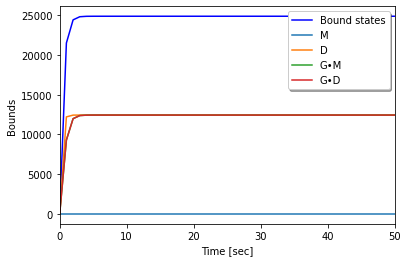

In [12]:
run_N0(m, mols, obs0)

## The multiary complex model

### Monovalent model (N = 1 and kx > 0)

In [13]:
# this is the monovalent model : N=1
N = 1.00

# Inputs :
# Ligand and G-protein concentrations
L = 1.00
G = 1.00

# scaling factor
alpha = 1.00

# The lumped dimensionless parameter (kx > 0)
kx = 0.001

# get model-parameters
par = ParConfigs()

mols = ["r", "rr", "R", "rR", "RR", "Gr", "Grr", "GR", "GrR", "GRR"]

obs0 = numpy.zeros(shape=(len(mols)))
obs0[0] = par.get_r0()

###############################################################
print ('Model-order: N =', N)
print ('Ligand: L =', L)
print ('G-protein: G =', G)
print ('alpha-factor: a =', alpha)
print ('Initial condition:')
for i in range(len(mols)) :
    print ('  ', mols[i], ': ', obs0[i])
###############################################################

# ligands-receptors first-order coupling
dl0, dl1, dl2 = par.get_dl()
kl0, kl1, kl2 = par.get_kl(100, 100)

# Gproteins-receptors first-order coupling
dg0, dg1 = par.get_dg()
kg0, kg1 = par.get_kg(100)

# ligand-(Gproteins-receptors) first-order coupling
da0, da1, da2 = par.get_da()
ka0, ka1, ka2 = par.get_ka(alpha, 100, 100)

# Gproteins-(ligand-receptors) first-order coupling
db0, db1, db2 = par.get_db()
kb0, kb1, kb2 = par.get_kb(alpha, 100, 100)

# receptor-receptor second-order coupling
dx0, dx1, dx2 = par.get_dx()
kx0, kx1, kx2 = par.get_kx(kx, N)

# receptor-Gprotein second-order coupling
dy0, dy1, dy2, dy3 = par.get_dy()
ky0, ky1, ky2, ky3 = par.get_ky(1, 1, 1, 1)

Model-order: N = 1.0
Ligand: L = 1.0
G-protein: G = 1.0
alpha-factor: a = 1.0
Initial condition:
   r :  49770.0
   rr :  0.0
   R :  0.0
   rR :  0.0
   RR :  0.0
   Gr :  0.0
   Grr :  0.0
   GR :  0.0
   GrR :  0.0
   GRR :  0.0


In [14]:
with reaction_rules():

    # TCM (Ternary complex model)
    r  == R  | (kl0*L, dl0)
    R  == GR | (ka0*G, da0)
    r  == Gr | (kg0*G, dg0)
    Gr == GR | (kb0*L, db0)

    # receptor dimerization
    r + r == rr | (kx0, dx0)
    R + r == rR | (kx1, dx1)
    R + R == RR | (kx2, dx2)

    rr == rR | (kl1*L, dl1)
    rR == RR | (kl2*L, dl2)

    # dimers coupled with G-proteins
    rr == Grr | (kg1*G, dg1)
    rR == GrR | (kb1*G, db1)
    RR == GRR | (kb2*G, db2)

    Gr + r == Grr | (ky0, dy0)
    GR + r == GrR | (ky1, dy1)
    Gr + R == GrR | (ky2, dy2)
    GR + R == GrR | (ky3, dy3)

    Grr == GrR | (ka1*L, da1)
    GrR == GRR | (ka2*L, da2)

m = get_model()
show(m)


r > R | 1.0
R > r | 1.0
R > GR | 1.0
GR > R | 1.0
r > Gr | 1.0
Gr > r | 1.0
Gr > GR | 1.0
GR > Gr | 1.0
r + r > rr | 0.00020092425155716296
rr > r + r | 1.0
R + r > rR | 2.0092425155716294e-06
rR > R + r | 1.0
R + R > RR | 2.0092425155716296e-08
RR > R + R | 1.0
rr > rR | 0.01
rR > rr | 1.0
rR > RR | 0.01
RR > rR | 1.0
rr > Grr | 0.01
Grr > rr | 1.0
rR > GrR | 0.01
GrR > rR | 1.0
RR > GRR | 0.01
GRR > RR | 1.0
Gr + r > Grr | 0.00020092425155716296
Grr > Gr + r | 1.0
GR + r > GrR | 2.0092425155716294e-06
GrR > GR + r | 1.0
Gr + R > GrR | 2.0092425155716294e-06
GrR > Gr + R | 1.0
GR + R > GrR | 2.0092425155716296e-08
GrR > GR + R | 1.0
Grr > GrR | 0.01
GrR > Grr | 1.0
GrR > GRR | 0.01
GRR > GrR | 1.0


Initial condition
r : 49770
rr : 0
R : 0
rR : 0
RR : 0
Gr : 0
Grr : 0
GR : 0
GrR : 0
GRR : 0


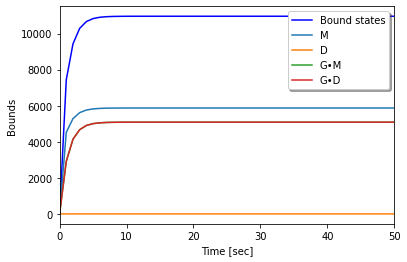

In [15]:
run_N1(m, mols, obs0)

### Bivalent model (N = 2 and kx > 0)

In [0]:
# this is the bivalent model : N=2
N = 2.00

mols = ["r", "rr", "rrr", "rrrr",
        "R", "rR", "rrR", "rrrR",
        "RR", "rRR", "rrRR",
        "Gr", "Grr", "Grrr", "Grrrr",
        "GR", "GrR", "GrrR", "GrrrR",
        "GRR", "GrRR", "GrrRR"]

In [17]:
with reaction_rules():

    # TCM (Ternary complex model)
    r  == R  | (kl0*L, dl0)
    R  == GR | (ka0*G, da0)
    r  == Gr | (kg0*G, dg0)
    Gr == GR | (kb0*L, db0)

    # receptor dimerization
    r  + r  == rr   | (kx0, dx0)
    r  + rr == rrr  | (kx0, dx0)
    rr + r  == rrr  | (kx0, dx0)
    rr + rr == rrrr | (kx0, dx0)

    R  + r  == rR   | (kx1, dx1)
    R  + rr == rrR  | (kx1, dx1)
    rR + r  == rrR  | (kx1, dx1)
    rR + rr == rrrR | (kx1, dx1)

    R  + R  == RR   | (kx2, dx2)
    R  + rR == rRR  | (kx2, dx2)
    rR + R  == rRR  | (kx2, dx2)
    rR + rR == rrRR | (kx2, dx2)

    rr   == rR   | (kl1*L, dl1)
    rrr  == rrR  | (kl1*L, dl1)
    rrrr == rrrR | (kl1*L, dl1)

    rR   == RR   | (kl2*L, dl2)
    rrR  == rRR  | (kl2*L, dl2)
    rrrR == rrRR | (kl2*L, dl2)

    # dimers coupled with G-proteins
    rr   == Grr   | (kg1*G, dg1)
    rrr  == Grrr  | (kg1*G, dg1)
    rrrr == Grrrr | (kg1*G, dg1)

    rR   == GrR   | (kb1*G, db1)
    rrR  == GrrR  | (kb1*G, db1)
    rrrR == GrrrR | (kb1*G, db1)

    RR   == GRR   | (kb2*G, db2)
    rRR  == GrRR  | (kb2*G, db2)
    rrRR == GrrRR | (kb2*G, db2)

    Gr  + r  == Grr   | (ky0, dy0)
    Gr  + rr == Grrr  | (ky0, dy0)
    Grr + r  == Grrr  | (ky0, dy0)
    Grr + rr == Grrrr | (ky0, dy0)

    GR  + r  == GrR   | (ky1, dy1)
    GR  + rr == GrrR  | (ky1, dy1)
    GrR + r  == GrrR  | (ky1, dy1)
    GrR + rr == GrrrR | (ky1, dy1)

    R  + Gr  == GrR   | (ky2, dy2)
    R  + Grr == GrrR  | (ky2, dy2)
    rR + Gr  == GrrR  | (ky2, dy2)
    rR + Grr == GrrrR | (ky2, dy2)

    GR  + R  == GRR   | (ky3, dy3)
    GR  + rR == GrRR  | (ky3, dy3)
    GrR + R  == GrRR  | (ky3, dy3)
    GrR + rR == GrrRR | (ky3, dy3)

    Grr   == GrR   | (ka1*L, da1)
    Grrr  == GrrR  | (ka1*L, da1)
    Grrrr == GrrrR | (ka1*L, da1)

    GrR   == GRR   | (ka2*L, da2)
    GrrR  == GrRR  | (ka2*L, da2)
    GrrrR == GrrRR | (ka2*L, da2)

m = get_model()
show(m)


r > R | 1.0
R > r | 1.0
R > GR | 1.0
GR > R | 1.0
r > Gr | 1.0
Gr > r | 1.0
Gr > GR | 1.0
GR > Gr | 1.0
r + r > rr | 0.00020092425155716296
rr > r + r | 1.0
r + rr > rrr | 0.00020092425155716296
rrr > r + rr | 1.0
rr + r > rrr | 0.00020092425155716296
rrr > rr + r | 1.0
rr + rr > rrrr | 0.00020092425155716296
rrrr > rr + rr | 1.0
R + r > rR | 2.0092425155716294e-06
rR > R + r | 1.0
R + rr > rrR | 2.0092425155716294e-06
rrR > R + rr | 1.0
rR + r > rrR | 2.0092425155716294e-06
rrR > rR + r | 1.0
rR + rr > rrrR | 2.0092425155716294e-06
rrrR > rR + rr | 1.0
R + R > RR | 2.0092425155716296e-08
RR > R + R | 1.0
R + rR > rRR | 2.0092425155716296e-08
rRR > R + rR | 1.0
rR + R > rRR | 2.0092425155716296e-08
rRR > rR + R | 1.0
rR + rR > rrRR | 2.0092425155716296e-08
rrRR > rR + rR | 1.0
rr > rR | 0.01
rR > rr | 1.0
rrr > rrR | 0.01
rrR > rrr | 1.0
rrrr > rrrR | 0.01
rrrR > rrrr | 1.0
rR > RR | 0.01
RR > rR | 1.0
rrR > rRR | 0.01
rRR > rrR | 1.0
rrrR > rrRR | 0.01
rrRR > rrrR | 1.0
rr > Grr | 0.

Initial condition
r : 49770
rr : 0
rrr : 0
rrrr : 0
R : 0
rR : 0
rrR : 0
rrrR : 0
RR : 0
rRR : 0
rrRR : 0
Gr : 0
Grr : 0
Grrr : 0
Grrrr : 0
GR : 0
GrR : 0
GrrR : 0
GrrrR : 0
GRR : 0
GrRR : 0
GrrRR : 0


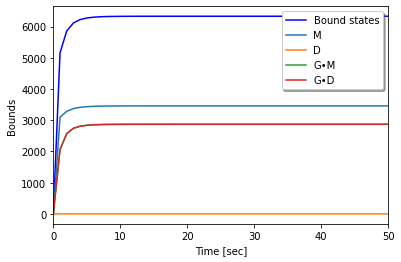

In [18]:
obs0 = numpy.zeros(shape=(len(mols)))
obs0[0] = par.get_r0()
run_N2(m, mols, obs0)

### Trivalent model (N = 3 and kx > 0)

In [0]:
# this is the trivalent model : N=3
N = 3.00

mols = ["r", "rr", "rrr", "rrrr", "rrrrr", "rrrrrr",
        "R", "rR", "rrR", "rrrR", "rrrrR", "rrrrrR",
        "RR", "rRR", "rrRR", "rrrRR", "rrrrRR",
        "Gr", "Grr", "Grrr", "Grrrr", "Grrrrr", "Grrrrrr",
        "GR", "GrR", "GrrR", "GrrrR", "GrrrrR", "GrrrrrR",
        "GRR", "GrRR", "GrrRR", "GrrrRR", "GrrrrRR"]

In [20]:
with reaction_rules():

    # TCM (Ternary complex model)
    r  == R  | (kl0*L, dl0)
    R  == GR | (ka0*G, da0)
    r  == Gr | (kg0*G, dg0)
    Gr == GR | (kb0*L, db0)

    # receptor dimerization
    r   + r   == rr     | (kx0, dx0)
    r   + rr  == rrr    | (kx0, dx0)
    r   + rrr == rrrr   | (kx0, dx0)
    rr  + r   == rrr    | (kx0, dx0)
    rr  + rr  == rrrr   | (kx0, dx0)
    rr  + rrr == rrrrr  | (kx0, dx0)
    rrr + r   == rrrr   | (kx0, dx0)
    rrr + rr  == rrrrr  | (kx0, dx0)
    rrr + rrr == rrrrrr | (kx0, dx0)

    R   + r   == rR     | (kx1, dx1)
    R   + rr  == rrR    | (kx1, dx1)
    R   + rrr == rrrR   | (kx1, dx1)
    rR  + r   == rrR    | (kx1, dx1)
    rR  + rr  == rrrR   | (kx1, dx1)
    rR  + rrr == rrrrR  | (kx1, dx1)
    rrR + r   == rrrR   | (kx1, dx1)
    rrR + rr  == rrrrR  | (kx1, dx1)
    rrR + rrr == rrrrrR | (kx1, dx1)

    R   + R   == RR     | (kx2, dx2)
    R   + rR  == rRR    | (kx2, dx2)
    R   + rrR == rrRR   | (kx2, dx2)
    rR  + R   == rRR    | (kx2, dx2)
    rR  + rR  == rrRR   | (kx2, dx2)
    rR  + rrR == rrrRR  | (kx2, dx2)
    rrR + R   == rrRR   | (kx2, dx2)
    rrR + rR  == rrrRR  | (kx2, dx2)
    rrR + rrR == rrrrRR | (kx2, dx2)

    rr     == rR     | (kl1*L, dl1)
    rrr    == rrR    | (kl1*L, dl1)
    rrrr   == rrrR   | (kl1*L, dl1)
    rrrrr  == rrrrR  | (kl1*L, dl1)
    rrrrrr == rrrrrR | (kl1*L, dl1)

    rR     == RR     | (kl2*L, dl2)
    rrR    == rRR    | (kl2*L, dl2)
    rrrR   == rrRR   | (kl2*L, dl2)
    rrrrR  == rrrRR  | (kl2*L, dl2)
    rrrrrR == rrrrRR | (kl2*L, dl2)

    # dimers coupled with G-proteins
    rr     == Grr     | (kg1*G, dg1)
    rrr    == Grrr    | (kg1*G, dg1)
    rrrr   == Grrrr   | (kg1*G, dg1)
    rrrrr  == Grrrrr  | (kg1*G, dg1)
    rrrrrr == Grrrrrr | (kg1*G, dg1)

    rR     == GrR     | (kb1*G, db1)
    rrR    == GrrR    | (kb1*G, db1)
    rrrR   == GrrrR   | (kb1*G, db1)
    rrrrR  == GrrrrR  | (kb1*G, db1)
    rrrrrR == GrrrrrR | (kb1*G, db1)

    RR     == GRR     | (kb2*G, db2)
    rRR    == GrRR    | (kb2*G, db2)
    rrRR   == GrrRR   | (kb2*G, db2)
    rrrRR  == GrrrRR  | (kb2*G, db2)
    rrrrRR == GrrrrRR | (kb2*G, db2)

    Gr   + r   == Grr     | (ky0, dy0)
    Gr   + rr  == Grrr    | (ky0, dy0)
    Gr   + rrr == Grrrr   | (ky0, dy0)
    Grr  + r   == Grrr    | (ky0, dy0)
    Grr  + rr  == Grrrr   | (ky0, dy0)
    Grr  + rrr == Grrrrr  | (ky0, dy0)
    Grrr + r   == Grrrr   | (ky0, dy0)
    Grrr + rr  == Grrrrr  | (ky0, dy0)
    Grrr + rrr == Grrrrrr | (ky0, dy0)

    GR   + r   == GrR     | (ky1, dy1)
    GR   + rr  == GrrR    | (ky1, dy1)
    GR   + rrr == GrrrR   | (ky1, dy1)
    GrR  + r   == GrrR    | (ky1, dy1)
    GrR  + rr  == GrrrR   | (ky1, dy1)
    GrR  + rrr == GrrrrR  | (ky1, dy1)
    GrrR + r   == GrrrR   | (ky1, dy1)
    GrrR + rr  == GrrrrR  | (ky1, dy1)
    GrrR + rrr == GrrrrrR | (ky1, dy1)

    R   + Gr   == GrR     | (ky2, dy2)
    R   + Grr  == GrrR    | (ky2, dy2)
    R   + Grrr == GrrrR   | (ky2, dy2)
    rR  + Gr   == GrrR    | (ky2, dy2)
    rR  + Grr  == GrrrR   | (ky2, dy2)
    rR  + Grrr == GrrrrR  | (ky2, dy2)
    rrR + Gr   == GrrrR   | (ky2, dy2)
    rrR + Grr  == GrrrrR  | (ky2, dy2)
    rrR + Grrr == GrrrrrR | (ky2, dy2)

    GR   + R   == GRR     | (ky3, dy3)
    GR   + rR  == GrRR    | (ky3, dy3)
    GR   + rrR == GrrRR   | (ky3, dy3)
    GrR  + R   == GrRR    | (ky3, dy3)
    GrR  + rR  == GrrRR   | (ky3, dy3)
    GrR  + rrR == GrrrRR  | (ky3, dy3)
    GrrR + R   == GrrRR   | (ky3, dy3)
    GrrR + rR  == GrrrRR  | (ky3, dy3)
    GrrR + rrR == GrrrrRR | (ky3, dy3)

    Grr     == GrR     | (ka1*L, da1)
    Grrr    == GrrR    | (ka1*L, da1)
    Grrrr   == GrrrR   | (ka1*L, da1)
    Grrrrr  == GrrrrR  | (ka1*L, da1)
    Grrrrrr == GrrrrrR | (ka1*L, da1)

    GrR     == GRR     | (ka2*L, da2)
    GrrR    == GrRR    | (ka2*L, da2)
    GrrrR   == GrrRR   | (ka2*L, da2)
    GrrrrR  == GrrrRR  | (ka2*L, da2)
    GrrrrrR == GrrrrRR | (ka2*L, da2)

m = get_model()
show(m)


r > R | 1.0
R > r | 1.0
R > GR | 1.0
GR > R | 1.0
r > Gr | 1.0
Gr > r | 1.0
Gr > GR | 1.0
GR > Gr | 1.0
r + r > rr | 0.00020092425155716296
rr > r + r | 1.0
r + rr > rrr | 0.00020092425155716296
rrr > r + rr | 1.0
r + rrr > rrrr | 0.00020092425155716296
rrrr > r + rrr | 1.0
rr + r > rrr | 0.00020092425155716296
rrr > rr + r | 1.0
rr + rr > rrrr | 0.00020092425155716296
rrrr > rr + rr | 1.0
rr + rrr > rrrrr | 0.00020092425155716296
rrrrr > rr + rrr | 1.0
rrr + r > rrrr | 0.00020092425155716296
rrrr > rrr + r | 1.0
rrr + rr > rrrrr | 0.00020092425155716296
rrrrr > rrr + rr | 1.0
rrr + rrr > rrrrrr | 0.00020092425155716296
rrrrrr > rrr + rrr | 1.0
R + r > rR | 2.0092425155716294e-06
rR > R + r | 1.0
R + rr > rrR | 2.0092425155716294e-06
rrR > R + rr | 1.0
R + rrr > rrrR | 2.0092425155716294e-06
rrrR > R + rrr | 1.0
rR + r > rrR | 2.0092425155716294e-06
rrR > rR + r | 1.0
rR + rr > rrrR | 2.0092425155716294e-06
rrrR > rR + rr | 1.0
rR + rrr > rrrrR | 2.0092425155716294e-06
rrrrR > rR + rr

Initial condition
r : 49770
rr : 0
rrr : 0
rrrr : 0
rrrrr : 0
rrrrrr : 0
R : 0
rR : 0
rrR : 0
rrrR : 0
rrrrR : 0
rrrrrR : 0
RR : 0
rRR : 0
rrRR : 0
rrrRR : 0
rrrrRR : 0
Gr : 0
Grr : 0
Grrr : 0
Grrrr : 0
Grrrrr : 0
Grrrrrr : 0
GR : 0
GrR : 0
GrrR : 0
GrrrR : 0
GrrrrR : 0
GrrrrrR : 0
GRR : 0
GrRR : 0
GrrRR : 0
GrrrRR : 0
GrrrrRR : 0


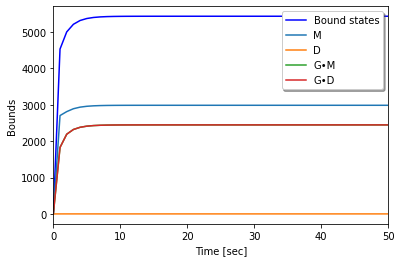

In [21]:
obs0 = numpy.zeros(shape=(len(mols)))
obs0[0] = par.get_r0()
run_N3(m, mols, obs0)

### Tetravalent model (N = 4 and kx > 0)

In [0]:
# this is the tetravalent model : N=4
N = 4.00

mols = ["r", "rr", "rrr", "rrrr", "rrrrr", "rrrrrr", "rrrrrrr", "rrrrrrrr",
        "R", "rR", "rrR", "rrrR", "rrrrR", "rrrrrR", "rrrrrrR", "rrrrrrrR",
        "RR", "rRR", "rrRR", "rrrRR", "rrrrRR", "rrrrrRR", "rrrrrrRR",
        "Gr", "Grr", "Grrr", "Grrrr", "Grrrrr", "Grrrrrr", "Grrrrrrr", "Grrrrrrrr",
        "GR", "GrR", "GrrR", "GrrrR", "GrrrrR", "GrrrrrR", "GrrrrrrR", "GrrrrrrrR",
        "GRR", "GrRR", "GrrRR", "GrrrRR", "GrrrrRR", "GrrrrrRR", "GrrrrrrRR"]

In [23]:
with reaction_rules():

    # TCM (Ternary complex model)
    r  == R  | (kl0*L, dl0)
    R  == GR | (ka0*G, da0)
    r  == Gr | (kg0*G, dg0)
    Gr == GR | (kb0*L, db0)

    # receptor dimerization
    r    + r    == rr       | (kx0, dx0)
    r    + rr   == rrr      | (kx0, dx0)
    r    + rrr  == rrrr     | (kx0, dx0)
    r    + rrrr == rrrrr    | (kx0, dx0)
    rr   + r    == rrr      | (kx0, dx0)
    rr   + rr   == rrrr     | (kx0, dx0)
    rr   + rrr  == rrrrr    | (kx0, dx0)
    rr   + rrrr == rrrrrr   | (kx0, dx0)
    rrr  + r    == rrrr     | (kx0, dx0)
    rrr  + rr   == rrrrr    | (kx0, dx0)
    rrr  + rrr  == rrrrrr   | (kx0, dx0)
    rrr  + rrrr == rrrrrrr  | (kx0, dx0)
    rrrr + r    == rrrrr    | (kx0, dx0)
    rrrr + rr   == rrrrrr   | (kx0, dx0)
    rrrr + rrr  == rrrrrrr  | (kx0, dx0)
    rrrr + rrrr == rrrrrrrr | (kx0, dx0)

    R    + r    == rR       | (kx1, dx1)
    R    + rr   == rrR      | (kx1, dx1)
    R    + rrr  == rrrR     | (kx1, dx1)
    R    + rrrr == rrrrR    | (kx1, dx1)
    rR   + r    == rrR      | (kx1, dx1)
    rR   + rr   == rrrR     | (kx1, dx1)
    rR   + rrr  == rrrrR    | (kx1, dx1)
    rR   + rrrr == rrrrrR   | (kx1, dx1)
    rrR  + r    == rrrR     | (kx1, dx1)
    rrR  + rr   == rrrrR    | (kx1, dx1)
    rrR  + rrr  == rrrrrR   | (kx1, dx1)
    rrR  + rrrr == rrrrrrR  | (kx1, dx1)
    rrrR + r    == rrrrR    | (kx1, dx1)
    rrrR + rr   == rrrrrR   | (kx1, dx1)
    rrrR + rrr  == rrrrrrR  | (kx1, dx1)
    rrrR + rrrr == rrrrrrrR | (kx1, dx1)

    R    + R    == RR       | (kx2, dx2)
    R    + rR   == rRR      | (kx2, dx2)
    R    + rrR  == rrRR     | (kx2, dx2)
    R    + rrrR == rrrRR    | (kx2, dx2)
    rR   + R    == rRR      | (kx2, dx2)
    rR   + rR   == rrRR     | (kx2, dx2)
    rR   + rrR  == rrrRR    | (kx2, dx2)
    rR   + rrrR == rrrrRR   | (kx2, dx2)
    rrR  + R    == rrRR     | (kx2, dx2)
    rrR  + rR   == rrrRR    | (kx2, dx2)
    rrR  + rrR  == rrrrRR   | (kx2, dx2)
    rrR  + rrrR == rrrrrRR  | (kx2, dx2)
    rrrR + R    == rrrRR    | (kx2, dx2)
    rrrR + rR   == rrrrRR   | (kx2, dx2)
    rrrR + rrR  == rrrrrRR  | (kx2, dx2)
    rrrR + rrrR == rrrrrrRR | (kx2, dx2)

    rr       == rR       | (kl1*L, dl1)
    rrr      == rrR      | (kl1*L, dl1)
    rrrr     == rrrR     | (kl1*L, dl1)
    rrrrr    == rrrrR    | (kl1*L, dl1)
    rrrrrr   == rrrrrR   | (kl1*L, dl1)
    rrrrrrr  == rrrrrrR  | (kl1*L, dl1)
    rrrrrrrr == rrrrrrrR | (kl1*L, dl1)

    rR       == RR       | (kl2*L, dl2)
    rrR      == rRR      | (kl2*L, dl2)
    rrrR     == rrRR     | (kl2*L, dl2)
    rrrrR    == rrrRR    | (kl2*L, dl2)
    rrrrrR   == rrrrRR   | (kl2*L, dl2)
    rrrrrrR  == rrrrrRR  | (kl2*L, dl2)
    rrrrrrrR == rrrrrrRR | (kl2*L, dl2)

    # dimers coupled with G-proteins
    rr       == Grr       | (kg1*G, dg1)
    rrr      == Grrr      | (kg1*G, dg1)
    rrrr     == Grrrr     | (kg1*G, dg1)
    rrrrr    == Grrrrr    | (kg1*G, dg1)
    rrrrrr   == Grrrrrr   | (kg1*G, dg1)
    rrrrrrr  == Grrrrrrr  | (kg1*G, dg1)
    rrrrrrrr == Grrrrrrrr | (kg1*G, dg1)

    rR       == GrR       | (kb1*G, db1)
    rrR      == GrrR      | (kb1*G, db1)
    rrrR     == GrrrR     | (kb1*G, db1)
    rrrrR    == GrrrrR    | (kb1*G, db1)
    rrrrrR   == GrrrrrR   | (kb1*G, db1)
    rrrrrrR  == GrrrrrrR  | (kb1*G, db1)
    rrrrrrrR == GrrrrrrrR | (kb1*G, db1)

    RR       == GRR       | (kb2*G, db2)
    rRR      == GrRR      | (kb2*G, db2)
    rrRR     == GrrRR     | (kb2*G, db2)
    rrrRR    == GrrrRR    | (kb2*G, db2)
    rrrrRR   == GrrrrRR   | (kb2*G, db2)
    rrrrrRR  == GrrrrrRR  | (kb2*G, db2)
    rrrrrrRR == GrrrrrrRR | (kb2*G, db2)

    Gr    + r    == Grr       | (ky0, dy0)
    Gr    + rr   == Grrr      | (ky0, dy0)
    Gr    + rrr  == Grrrr     | (ky0, dy0)
    Gr    + rrrr == Grrrrr    | (ky0, dy0)
    Grr   + r    == Grrr      | (ky0, dy0)
    Grr   + rr   == Grrrr     | (ky0, dy0)
    Grr   + rrr  == Grrrrr    | (ky0, dy0)
    Grr   + rrrr == Grrrrrr   | (ky0, dy0)
    Grrr  + r    == Grrrr     | (ky0, dy0)
    Grrr  + rr   == Grrrrr    | (ky0, dy0)
    Grrr  + rrr  == Grrrrrr   | (ky0, dy0)
    Grrr  + rrrr == Grrrrrrr  | (ky0, dy0)
    Grrrr + r    == Grrrrr    | (ky0, dy0)
    Grrrr + rr   == Grrrrrr   | (ky0, dy0)
    Grrrr + rrr  == Grrrrrrr  | (ky0, dy0)
    Grrrr + rrrr == Grrrrrrrr | (ky0, dy0)

    GR    + r    == GrR       | (ky1, dy1)
    GR    + rr   == GrrR      | (ky1, dy1)
    GR    + rrr  == GrrrR     | (ky1, dy1)
    GR    + rrrr == GrrrrR    | (ky1, dy1)
    GrR   + r    == GrrR      | (ky1, dy1)
    GrR   + rr   == GrrrR     | (ky1, dy1)
    GrR   + rrr  == GrrrrR    | (ky1, dy1)
    GrR   + rrrr == GrrrrrR   | (ky1, dy1)
    GrrR  + r    == GrrrR     | (ky1, dy1)
    GrrR  + rr   == GrrrrR    | (ky1, dy1)
    GrrR  + rrr  == GrrrrrR   | (ky1, dy1)
    GrrR  + rrrr == GrrrrrrR  | (ky1, dy1)
    GrrrR + r    == GrrrrR    | (ky1, dy1)
    GrrrR + rr   == GrrrrrR   | (ky1, dy1)
    GrrrR + rrr  == GrrrrrrR  | (ky1, dy1)
    GrrrR + rrrr == GrrrrrrrR | (ky1, dy1)


    R    + Gr    == GrR       | (ky2, dy2)
    R    + Grr   == GrrR      | (ky2, dy2)
    R    + Grrr  == GrrrR     | (ky2, dy2)
    R    + Grrrr == GrrrrR    | (ky2, dy2)
    rR   + Gr    == GrrR      | (ky2, dy2)
    rR   + Grr   == GrrrR     | (ky2, dy2)
    rR   + Grrr  == GrrrrR    | (ky2, dy2)
    rR   + Grrrr == GrrrrrR   | (ky2, dy2)
    rrR  + Gr    == GrrrR     | (ky2, dy2)
    rrR  + Grr   == GrrrrR    | (ky2, dy2)
    rrR  + Grrr  == GrrrrrR   | (ky2, dy2)
    rrR  + Grrrr == GrrrrrrR  | (ky2, dy2)
    rrrR + Gr    == GrrrrR    | (ky2, dy2)
    rrrR + Grr   == GrrrrrR   | (ky2, dy2)
    rrrR + Grrr  == GrrrrrrR  | (ky2, dy2)
    rrrR + Grrrr == GrrrrrrrR | (ky2, dy2)

    GR    + R    == GRR       | (ky3, dy3)
    GR    + rR   == GrRR      | (ky3, dy3)
    GR    + rrR  == GrrRR     | (ky3, dy3)
    GR    + rrrR == GrrrRR    | (ky3, dy3)
    GrR   + R    == GrRR      | (ky3, dy3)
    GrR   + rR   == GrrRR     | (ky3, dy3)
    GrR   + rrR  == GrrrRR    | (ky3, dy3)
    GrR   + rrrR == GrrrrRR   | (ky3, dy3)
    GrrR  + R    == GrrRR     | (ky3, dy3)
    GrrR  + rR   == GrrrRR    | (ky3, dy3)
    GrrR  + rrR  == GrrrrRR   | (ky3, dy3)
    GrrR  + rrrR == GrrrrrRR  | (ky3, dy3)
    GrrrR + R    == GrrrRR    | (ky3, dy3)
    GrrrR + rR   == GrrrrRR   | (ky3, dy3)
    GrrrR + rrR  == GrrrrrRR  | (ky3, dy3)
    GrrrR + rrrR == GrrrrrrRR | (ky3, dy3)

    Grr       == GrR       | (ka1*L, da1)
    Grrr      == GrrR      | (ka1*L, da1)
    Grrrr     == GrrrR     | (ka1*L, da1)
    Grrrrr    == GrrrrR    | (ka1*L, da1)
    Grrrrrr   == GrrrrrR   | (ka1*L, da1)
    Grrrrrrr  == GrrrrrrR  | (ka1*L, da1)
    Grrrrrrrr == GrrrrrrrR | (ka1*L, da1)

    GrR       == GRR       | (ka2*L, da2)
    GrrR      == GrRR      | (ka2*L, da2)
    GrrrR     == GrrRR     | (ka2*L, da2)
    GrrrrR    == GrrrRR    | (ka2*L, da2)
    GrrrrrR   == GrrrrRR   | (ka2*L, da2)
    GrrrrrrR  == GrrrrrRR  | (ka2*L, da2)
    GrrrrrrrR == GrrrrrrRR | (ka2*L, da2)

m = get_model()
show(m)


r > R | 1.0
R > r | 1.0
R > GR | 1.0
GR > R | 1.0
r > Gr | 1.0
Gr > r | 1.0
Gr > GR | 1.0
GR > Gr | 1.0
r + r > rr | 0.00020092425155716296
rr > r + r | 1.0
r + rr > rrr | 0.00020092425155716296
rrr > r + rr | 1.0
r + rrr > rrrr | 0.00020092425155716296
rrrr > r + rrr | 1.0
r + rrrr > rrrrr | 0.00020092425155716296
rrrrr > r + rrrr | 1.0
rr + r > rrr | 0.00020092425155716296
rrr > rr + r | 1.0
rr + rr > rrrr | 0.00020092425155716296
rrrr > rr + rr | 1.0
rr + rrr > rrrrr | 0.00020092425155716296
rrrrr > rr + rrr | 1.0
rr + rrrr > rrrrrr | 0.00020092425155716296
rrrrrr > rr + rrrr | 1.0
rrr + r > rrrr | 0.00020092425155716296
rrrr > rrr + r | 1.0
rrr + rr > rrrrr | 0.00020092425155716296
rrrrr > rrr + rr | 1.0
rrr + rrr > rrrrrr | 0.00020092425155716296
rrrrrr > rrr + rrr | 1.0
rrr + rrrr > rrrrrrr | 0.00020092425155716296
rrrrrrr > rrr + rrrr | 1.0
rrrr + r > rrrrr | 0.00020092425155716296
rrrrr > rrrr + r | 1.0
rrrr + rr > rrrrrr | 0.00020092425155716296
rrrrrr > rrrr + rr | 1.0
rrrr 

Initial condition
r : 49770
rr : 0
rrr : 0
rrrr : 0
rrrrr : 0
rrrrrr : 0
rrrrrrr : 0
rrrrrrrr : 0
R : 0
rR : 0
rrR : 0
rrrR : 0
rrrrR : 0
rrrrrR : 0
rrrrrrR : 0
rrrrrrrR : 0
RR : 0
rRR : 0
rrRR : 0
rrrRR : 0
rrrrRR : 0
rrrrrRR : 0
rrrrrrRR : 0
Gr : 0
Grr : 0
Grrr : 0
Grrrr : 0
Grrrrr : 0
Grrrrrr : 0
Grrrrrrr : 0
Grrrrrrrr : 0
GR : 0
GrR : 0
GrrR : 0
GrrrR : 0
GrrrrR : 0
GrrrrrR : 0
GrrrrrrR : 0
GrrrrrrrR : 0
GRR : 0
GrRR : 0
GrrRR : 0
GrrrRR : 0
GrrrrRR : 0
GrrrrrRR : 0
GrrrrrrRR : 0


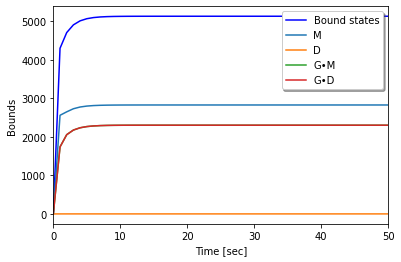

In [24]:
obs0 = numpy.zeros(shape=(len(mols)))
obs0[0] = par.get_r0()
run_N4(m, mols, obs0)

### Pentavalent model (N = 5 and kx > 0)

In [0]:
# this is the pentavalent model : N=5
N = 5.00

mols =  ["r", "rr", "rrr", "rrrr", "rrrrr", "rrrrrr", "rrrrrrr", "rrrrrrrr", "rrrrrrrr", "rrrrrrrrrr",
         "R", "rR", "rrR", "rrrR", "rrrrR", "rrrrrR", "rrrrrrR", "rrrrrrrR", "rrrrrrrR", "rrrrrrrrrR",
         "RR", "rRR", "rrRR", "rrrRR", "rrrrRR", "rrrrrRR", "rrrrrrRR", "rrrrrrRR", "rrrrrrrrRR",
         "Gr", "Grr", "Grrr", "Grrrr", "Grrrrr", "Grrrrrr", "Grrrrrrr", "Grrrrrrrr", "Grrrrrrrr", "Grrrrrrrrrr",
         "GR", "GrR", "GrrR", "GrrrR", "GrrrrR", "GrrrrrR", "GrrrrrrR", "GrrrrrrrR", "GrrrrrrrR", "GrrrrrrrrrR",
         "GRR", "GrRR", "GrrRR", "GrrrRR", "GrrrrRR", "GrrrrrRR", "GrrrrrrRR", "GrrrrrrRR", "GrrrrrrrrRR"]

In [26]:
with reaction_rules():

    # TCM (Ternary complex model)
    r  == R  | (kl0*L, dl0)
    R  == GR | (ka0*G, da0)
    r  == Gr | (kg0*G, dg0)
    Gr == GR | (kb0*L, db0)

    # receptor dimerization
    r     + r     == rr         | (kx0, dx0)
    r     + rr    == rrr        | (kx0, dx0)
    r     + rrr   == rrrr       | (kx0, dx0)
    r     + rrrr  == rrrrr      | (kx0, dx0)
    r     + rrrrr == rrrrrr     | (kx0, dx0)
    rr    + r     == rrr        | (kx0, dx0)
    rr    + rr    == rrrr       | (kx0, dx0)
    rr    + rrr   == rrrrr      | (kx0, dx0)
    rr    + rrrr  == rrrrrr     | (kx0, dx0)
    rr    + rrrrr == rrrrrrr    | (kx0, dx0)
    rrr   + r     == rrrr       | (kx0, dx0)
    rrr   + rr    == rrrrr      | (kx0, dx0)
    rrr   + rrr   == rrrrrr     | (kx0, dx0)
    rrr   + rrrr  == rrrrrrr    | (kx0, dx0)
    rrr   + rrrrr == rrrrrrrr   | (kx0, dx0)
    rrrr  + r     == rrrrr      | (kx0, dx0)
    rrrr  + rr    == rrrrrr     | (kx0, dx0)
    rrrr  + rrr   == rrrrrrr    | (kx0, dx0)
    rrrr  + rrrr  == rrrrrrrr   | (kx0, dx0)
    rrrr  + rrrrr == rrrrrrrrr  | (kx0, dx0)
    rrrrr + r     == rrrrrr     | (kx0, dx0)
    rrrrr + rr    == rrrrrrr    | (kx0, dx0)
    rrrrr + rrr   == rrrrrrrr   | (kx0, dx0)
    rrrrr + rrrr  == rrrrrrrrr  | (kx0, dx0)
    rrrrr + rrrrr == rrrrrrrrrr | (kx0, dx0)

    R     + r     == rR         | (kx1, dx1)
    R     + rr    == rrR        | (kx1, dx1)
    R     + rrr   == rrrR       | (kx1, dx1)
    R     + rrrr  == rrrrR      | (kx1, dx1)
    R     + rrrrr == rrrrrR     | (kx1, dx1)
    rR    + r     == rrR        | (kx1, dx1)
    rR    + rr    == rrrR       | (kx1, dx1)
    rR    + rrr   == rrrrR      | (kx1, dx1)
    rR    + rrrr  == rrrrrR     | (kx1, dx1)
    rR    + rrrrr == rrrrrrR    | (kx1, dx1)
    rrR   + r     == rrrR       | (kx1, dx1)
    rrR   + rr    == rrrrR      | (kx1, dx1)
    rrR   + rrr   == rrrrrR     | (kx1, dx1)
    rrR   + rrrr  == rrrrrrR    | (kx1, dx1)
    rrR   + rrrrr == rrrrrrrR   | (kx1, dx1)
    rrrR  + r     == rrrrR      | (kx1, dx1)
    rrrR  + rr    == rrrrrR     | (kx1, dx1)
    rrrR  + rrr   == rrrrrrR    | (kx1, dx1)
    rrrR  + rrrr  == rrrrrrrR   | (kx1, dx1)
    rrrR  + rrrrr == rrrrrrrrR  | (kx1, dx1)
    rrrrR + r     == rrrrrR     | (kx1, dx1)
    rrrrR + rr    == rrrrrrR    | (kx1, dx1)
    rrrrR + rrr   == rrrrrrrR   | (kx1, dx1)
    rrrrR + rrrr  == rrrrrrrrR  | (kx1, dx1)
    rrrrR + rrrrr == rrrrrrrrrR | (kx1, dx1)

    R     + R     == RR         | (kx2, dx2)
    R     + rR    == rRR        | (kx2, dx2)
    R     + rrR   == rrRR       | (kx2, dx2)
    R     + rrrR  == rrrRR      | (kx2, dx2)
    R     + rrrrR == rrrrRR     | (kx2, dx2)
    rR    + R     == rRR        | (kx2, dx2)
    rR    + rR    == rrRR       | (kx2, dx2)
    rR    + rrR   == rrrRR      | (kx2, dx2)
    rR    + rrrR  == rrrrRR     | (kx2, dx2)
    rR    + rrrrR == rrrrrRR    | (kx2, dx2)
    rrR   + R     == rrRR       | (kx2, dx2)
    rrR   + rR    == rrrRR      | (kx2, dx2)
    rrR   + rrR   == rrrrRR     | (kx2, dx2)
    rrR   + rrrR  == rrrrrRR    | (kx2, dx2)
    rrR   + rrrrR == rrrrrrRR   | (kx2, dx2)
    rrrR  + R     == rrrRR      | (kx2, dx2)
    rrrR  + rR    == rrrrRR     | (kx2, dx2)
    rrrR  + rrR   == rrrrrRR    | (kx2, dx2)
    rrrR  + rrrR  == rrrrrrRR   | (kx2, dx2)
    rrrR  + rrrrR == rrrrrrrRR  | (kx2, dx2)
    rrrrR + R     == rrrrRR     | (kx2, dx2)
    rrrrR + rR    == rrrrrRR    | (kx2, dx2)
    rrrrR + rrR   == rrrrrrRR   | (kx2, dx2)
    rrrrR + rrrR  == rrrrrrrRR  | (kx2, dx2)
    rrrrR + rrrrR == rrrrrrrrRR | (kx2, dx2)

    rr         == rR         | (kl1*L, dl1)
    rrr        == rrR        | (kl1*L, dl1)
    rrrr       == rrrR       | (kl1*L, dl1)
    rrrrr      == rrrrR      | (kl1*L, dl1)
    rrrrrr     == rrrrrR     | (kl1*L, dl1)
    rrrrrrr    == rrrrrrR    | (kl1*L, dl1)
    rrrrrrrr   == rrrrrrrR   | (kl1*L, dl1)
    rrrrrrrrr  == rrrrrrrrR  | (kl1*L, dl1)
    rrrrrrrrrr == rrrrrrrrrR | (kl1*L, dl1)

    rR         == RR         | (kl2*L, dl2)
    rrR        == rRR        | (kl2*L, dl2)
    rrrR       == rrRR       | (kl2*L, dl2)
    rrrrR      == rrrRR      | (kl2*L, dl2)
    rrrrrR     == rrrrRR     | (kl2*L, dl2)
    rrrrrrR    == rrrrrRR    | (kl2*L, dl2)
    rrrrrrrR   == rrrrrrRR   | (kl2*L, dl2)
    rrrrrrrrR  == rrrrrrrRR  | (kl2*L, dl2)
    rrrrrrrrrR == rrrrrrrrRR | (kl2*L, dl2)

    # dimers coupled with G-proteins
    rr         == Grr         | (kg1*G, dg1)
    rrr        == Grrr        | (kg1*G, dg1)
    rrrr       == Grrrr       | (kg1*G, dg1)
    rrrrr      == Grrrrr      | (kg1*G, dg1)
    rrrrrr     == Grrrrrr     | (kg1*G, dg1)
    rrrrrrr    == Grrrrrrr    | (kg1*G, dg1)
    rrrrrrrr   == Grrrrrrrr   | (kg1*G, dg1)
    rrrrrrrrr  == Grrrrrrrrr  | (kg1*G, dg1)
    rrrrrrrrrr == Grrrrrrrrrr | (kg1*G, dg1)

    rR         == GrR         | (kb1*G, db1)
    rrR        == GrrR        | (kb1*G, db1)
    rrrR       == GrrrR       | (kb1*G, db1)
    rrrrR      == GrrrrR      | (kb1*G, db1)
    rrrrrR     == GrrrrrR     | (kb1*G, db1)
    rrrrrrR    == GrrrrrrR    | (kb1*G, db1)
    rrrrrrrR   == GrrrrrrrR   | (kb1*G, db1)
    rrrrrrrrR  == GrrrrrrrrR  | (kb1*G, db1)
    rrrrrrrrrR == GrrrrrrrrrR | (kb1*G, db1)

    RR         == GRR         | (kb2*G, db2)
    rRR        == GrRR        | (kb2*G, db2)
    rrRR       == GrrRR       | (kb2*G, db2)
    rrrRR      == GrrrRR      | (kb2*G, db2)
    rrrrRR     == GrrrrRR     | (kb2*G, db2)
    rrrrrRR    == GrrrrrRR    | (kb2*G, db2)
    rrrrrrRR   == GrrrrrrRR   | (kb2*G, db2)
    rrrrrrrRR  == GrrrrrrrRR  | (kb2*G, db2)
    rrrrrrrrRR == GrrrrrrrrRR | (kb2*G, db2)

    Gr     + r     == Grr         | (ky0, dy0)
    Gr     + rr    == Grrr        | (ky0, dy0)
    Gr     + rrr   == Grrrr       | (ky0, dy0)
    Gr     + rrrr  == Grrrrr      | (ky0, dy0)
    Gr     + rrrrr == Grrrrrr     | (ky0, dy0)
    Grr    + r     == Grrr        | (ky0, dy0)
    Grr    + rr    == Grrrr       | (ky0, dy0)
    Grr    + rrr   == Grrrrr      | (ky0, dy0)
    Grr    + rrrr  == Grrrrrr     | (ky0, dy0)
    Grr    + rrrrr == Grrrrrrr    | (ky0, dy0)
    Grrr   + r     == Grrrr       | (ky0, dy0)
    Grrr   + rr    == Grrrrr      | (ky0, dy0)
    Grrr   + rrr   == Grrrrrr     | (ky0, dy0)
    Grrr   + rrrr  == Grrrrrrr    | (ky0, dy0)
    Grrr   + rrrrr == Grrrrrrrr   | (ky0, dy0)
    Grrrr  + r     == Grrrrr      | (ky0, dy0)
    Grrrr  + rr    == Grrrrrr     | (ky0, dy0)
    Grrrr  + rrr   == Grrrrrrr    | (ky0, dy0)
    Grrrr  + rrrr  == Grrrrrrrr   | (ky0, dy0)
    Grrrr  + rrrrr == Grrrrrrrrr  | (ky0, dy0)
    Grrrrr + r     == Grrrrrr     | (ky0, dy0)
    Grrrrr + rr    == Grrrrrrr    | (ky0, dy0)
    Grrrrr + rrr   == Grrrrrrrr   | (ky0, dy0)
    Grrrrr + rrrr  == Grrrrrrrrr  | (ky0, dy0)
    Grrrrr + rrrrr == Grrrrrrrrrr | (ky0, dy0)

    GR     + r     == GrR         | (ky1, dy1)
    GR     + rr    == GrrR        | (ky1, dy1)
    GR     + rrr   == GrrrR       | (ky1, dy1)
    GR     + rrrr  == GrrrrR      | (ky1, dy1)
    GR     + rrrrr == GrrrrrR     | (ky1, dy1)
    GrR    + r     == GrrR        | (ky1, dy1)
    GrR    + rr    == GrrrR       | (ky1, dy1)
    GrR    + rrr   == GrrrrR      | (ky1, dy1)
    GrR    + rrrr  == GrrrrrR     | (ky1, dy1)
    GrR    + rrrrr == GrrrrrrR    | (ky1, dy1)
    GrrR   + r     == GrrrR       | (ky1, dy1)
    GrrR   + rr    == GrrrrR      | (ky1, dy1)
    GrrR   + rrr   == GrrrrrR     | (ky1, dy1)
    GrrR   + rrrr  == GrrrrrrR    | (ky1, dy1)
    GrrR   + rrrrr == GrrrrrrrR   | (ky1, dy1)
    GrrrR  + r     == GrrrrR      | (ky1, dy1)
    GrrrR  + rr    == GrrrrrR     | (ky1, dy1)
    GrrrR  + rrr   == GrrrrrrR    | (ky1, dy1)
    GrrrR  + rrrr  == GrrrrrrrR   | (ky1, dy1)
    GrrrR  + rrrrr == GrrrrrrrrR  | (ky1, dy1)
    GrrrrR + r     == GrrrrrR     | (ky1, dy1)
    GrrrrR + rr    == GrrrrrrR    | (ky1, dy1)
    GrrrrR + rrr   == GrrrrrrrR   | (ky1, dy1)
    GrrrrR + rrrr  == GrrrrrrrrR  | (ky1, dy1)
    GrrrrR + rrrrr == GrrrrrrrrrR | (ky1, dy1)


    R     + Gr     == GrR         | (ky2, dy2)
    R     + Grr    == GrrR        | (ky2, dy2)
    R     + Grrr   == GrrrR       | (ky2, dy2)
    R     + Grrrr  == GrrrrR      | (ky2, dy2)
    R     + Grrrrr == GrrrrrR     | (ky2, dy2)
    rR    + Gr     == GrrR        | (ky2, dy2)
    rR    + Grr    == GrrrR       | (ky2, dy2)
    rR    + Grrr   == GrrrrR      | (ky2, dy2)
    rR    + Grrrr  == GrrrrrR     | (ky2, dy2)
    rR    + Grrrrr == GrrrrrrR    | (ky2, dy2)
    rrR   + Gr     == GrrrR       | (ky2, dy2)
    rrR   + Grr    == GrrrrR      | (ky2, dy2)
    rrR   + Grrr   == GrrrrrR     | (ky2, dy2)
    rrR   + Grrrr  == GrrrrrrR    | (ky2, dy2)
    rrR   + Grrrrr == GrrrrrrrR   | (ky2, dy2)
    rrrR  + Gr     == GrrrrR      | (ky2, dy2)
    rrrR  + Grr    == GrrrrrR     | (ky2, dy2)
    rrrR  + Grrr   == GrrrrrrR    | (ky2, dy2)
    rrrR  + Grrrr  == GrrrrrrrR   | (ky2, dy2)
    rrrR  + Grrrrr == GrrrrrrrrR  | (ky2, dy2)
    rrrrR + Gr     == GrrrrrR     | (ky2, dy2)
    rrrrR + Grr    == GrrrrrrR    | (ky2, dy2)
    rrrrR + Grrr   == GrrrrrrrR   | (ky2, dy2)
    rrrrR + Grrrr  == GrrrrrrrrR  | (ky2, dy2)
    rrrrR + Grrrrr == GrrrrrrrrrR | (ky2, dy2)

    GR     + R     == GRR         | (ky3, dy3)
    GR     + rR    == GrRR        | (ky3, dy3)
    GR     + rrR   == GrrRR       | (ky3, dy3)
    GR     + rrrR  == GrrrRR      | (ky3, dy3)
    GR     + rrrrR == GrrrrRR     | (ky3, dy3)
    GrR    + R     == GrRR        | (ky3, dy3)
    GrR    + rR    == GrrRR       | (ky3, dy3)
    GrR    + rrR   == GrrrRR      | (ky3, dy3)
    GrR    + rrrR  == GrrrrRR     | (ky3, dy3)
    GrR    + rrrrR == GrrrrrRR    | (ky3, dy3)
    GrrR   + R     == GrrRR       | (ky3, dy3)
    GrrR   + rR    == GrrrRR      | (ky3, dy3)
    GrrR   + rrR   == GrrrrRR     | (ky3, dy3)
    GrrR   + rrrR  == GrrrrrRR    | (ky3, dy3)
    GrrR   + rrrrR == GrrrrrrRR   | (ky3, dy3)
    GrrrR  + R     == GrrrRR      | (ky3, dy3)
    GrrrR  + rR    == GrrrrRR     | (ky3, dy3)
    GrrrR  + rrR   == GrrrrrRR    | (ky3, dy3)
    GrrrR  + rrrR  == GrrrrrrRR   | (ky3, dy3)
    GrrrR  + rrrrR == GrrrrrrrRR  | (ky3, dy3)
    GrrrrR + R     == GrrrrRR     | (ky3, dy3)
    GrrrrR + rR    == GrrrrrRR    | (ky3, dy3)
    GrrrrR + rrR   == GrrrrrrRR   | (ky3, dy3)
    GrrrrR + rrrR  == GrrrrrrrRR  | (ky3, dy3)
    GrrrrR + rrrrR == GrrrrrrrrRR | (ky3, dy3)

    Grr         == GrR         | (ka1*L, da1)
    Grrr        == GrrR        | (ka1*L, da1)
    Grrrr       == GrrrR       | (ka1*L, da1)
    Grrrrr      == GrrrrR      | (ka1*L, da1)
    Grrrrrr     == GrrrrrR     | (ka1*L, da1)
    Grrrrrrr    == GrrrrrrR    | (ka1*L, da1)
    Grrrrrrrr   == GrrrrrrrR   | (ka1*L, da1)
    Grrrrrrrrr  == GrrrrrrrrR  | (ka1*L, da1)
    Grrrrrrrrrr == GrrrrrrrrrR | (ka1*L, da1)

    GrR         == GRR         | (ka2*L, da2)
    GrrR        == GrRR        | (ka2*L, da2)
    GrrrR       == GrrRR       | (ka2*L, da2)
    GrrrrR      == GrrrRR      | (ka2*L, da2)
    GrrrrrR     == GrrrrRR     | (ka2*L, da2)
    GrrrrrrR    == GrrrrrRR    | (ka2*L, da2)
    GrrrrrrrR   == GrrrrrrRR   | (ka2*L, da2)
    GrrrrrrrrR  == GrrrrrrrRR  | (ka2*L, da2)
    GrrrrrrrrrR == GrrrrrrrrRR | (ka2*L, da2)

m = get_model()
show(m)


r > R | 1.0
R > r | 1.0
R > GR | 1.0
GR > R | 1.0
r > Gr | 1.0
Gr > r | 1.0
Gr > GR | 1.0
GR > Gr | 1.0
r + r > rr | 0.00020092425155716296
rr > r + r | 1.0
r + rr > rrr | 0.00020092425155716296
rrr > r + rr | 1.0
r + rrr > rrrr | 0.00020092425155716296
rrrr > r + rrr | 1.0
r + rrrr > rrrrr | 0.00020092425155716296
rrrrr > r + rrrr | 1.0
r + rrrrr > rrrrrr | 0.00020092425155716296
rrrrrr > r + rrrrr | 1.0
rr + r > rrr | 0.00020092425155716296
rrr > rr + r | 1.0
rr + rr > rrrr | 0.00020092425155716296
rrrr > rr + rr | 1.0
rr + rrr > rrrrr | 0.00020092425155716296
rrrrr > rr + rrr | 1.0
rr + rrrr > rrrrrr | 0.00020092425155716296
rrrrrr > rr + rrrr | 1.0
rr + rrrrr > rrrrrrr | 0.00020092425155716296
rrrrrrr > rr + rrrrr | 1.0
rrr + r > rrrr | 0.00020092425155716296
rrrr > rrr + r | 1.0
rrr + rr > rrrrr | 0.00020092425155716296
rrrrr > rrr + rr | 1.0
rrr + rrr > rrrrrr | 0.00020092425155716296
rrrrrr > rrr + rrr | 1.0
rrr + rrrr > rrrrrrr | 0.00020092425155716296
rrrrrrr > rrr + rrrr | 1

Initial condition
r : 49770
rr : 0
rrr : 0
rrrr : 0
rrrrr : 0
rrrrrr : 0
rrrrrrr : 0
rrrrrrrr : 0
rrrrrrrr : 0
rrrrrrrrrr : 0
R : 0
rR : 0
rrR : 0
rrrR : 0
rrrrR : 0
rrrrrR : 0
rrrrrrR : 0
rrrrrrrR : 0
rrrrrrrR : 0
rrrrrrrrrR : 0
RR : 0
rRR : 0
rrRR : 0
rrrRR : 0
rrrrRR : 0
rrrrrRR : 0
rrrrrrRR : 0
rrrrrrRR : 0
rrrrrrrrRR : 0
Gr : 0
Grr : 0
Grrr : 0
Grrrr : 0
Grrrrr : 0
Grrrrrr : 0
Grrrrrrr : 0
Grrrrrrrr : 0
Grrrrrrrr : 0
Grrrrrrrrrr : 0
GR : 0
GrR : 0
GrrR : 0
GrrrR : 0
GrrrrR : 0
GrrrrrR : 0
GrrrrrrR : 0
GrrrrrrrR : 0
GrrrrrrrR : 0
GrrrrrrrrrR : 0
GRR : 0
GrRR : 0
GrrRR : 0
GrrrRR : 0
GrrrrRR : 0
GrrrrrRR : 0
GrrrrrrRR : 0
GrrrrrrRR : 0
GrrrrrrrrRR : 0


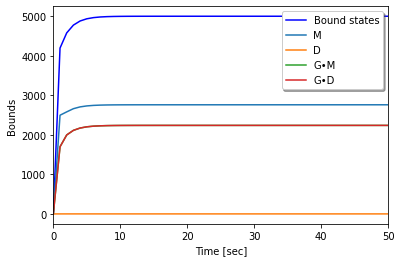

In [27]:
obs0 = numpy.zeros(shape=(len(mols)))
obs0[0] = par.get_r0()
run_N5(m, mols, obs0)